## Code to 
## (1) process M2AX data to create features/labels
## (2) develop ML (XGB) models to predict elastic modulus
## (3) optimize features using Bayesian Optimization
#### Ashwin B. Mhadeshwar (ashwin.b.mhadeshwar@gmail.com)

In [29]:
# Import packages.
# ----------
import os, joblib, random, warnings, json
from decimal import Decimal
from openpyxl import load_workbook
from itertools import compress, accumulate
from tqdm import tqdm
# ----------
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
# ----------
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.pipeline import Pipeline
import shap
# ----------
from xgboost import XGBRegressor
# ----------
%matplotlib inline
pd.set_option('display.max_rows', 40)
warnings.filterwarnings('ignore')
# ----------
my_percentiles = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99]
tab = '\t'
large_num = 1E32
small_num = 1E-32

#### Step 1: Load data

In [2]:
from matminer.datasets import get_all_dataset_info
from matminer.datasets.convenience_loaders import load_m2ax
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty

In [4]:
print(get_all_dataset_info("m2ax"))

Dataset: m2ax
Description: Elastic properties of 223 stable M2AX compounds from "A comprehensive survey of M2AX phase elastic properties" by Cover et al. Calculations are PAW PW91.
Columns:
	a: Lattice parameter a, in A (angstrom)
	bulk modulus: In GPa
	c: lattice parameter c, in A (angstrom)
	c11: Elastic constants of the M2AX material. These are specific to hexagonal materials.
	c12: Elastic constants of the M2AX material. These are specific to hexagonal materials.
	c13: Elastic constants of the M2AX material. These are specific to hexagonal materials.
	c33: Elastic constants of the M2AX material. These are specific to hexagonal materials.
	c44: Elastic constants of the M2AX material. These are specific to hexagonal materials.
	d_ma: distance from the M atom to the A atom
	d_mx: distance from the M atom to the X atom
	elastic modulus: In GPa
	formula: chemical formula
	shear modulus: In GPa
Num Entries: 223
Reference: http://iopscience.iop.org/article/10.1088/0953-8984/21/30/305403/m

In [6]:
# Load M2AX data.
df_orig = load_m2ax()
df_orig.head()

,formula,a,c,d_mx,d_ma,c11,c12,c13,c33,c44,bulk modulus,shear modulus,elastic modulus
0,Sc2AlC,3.297,15.04,1.242,2.517,175,59,33,191,44,88,57,140
1,Sc2AlN,3.217,14.53,1.231,2.401,213,60,48,228,72,107,77,187
2,Sc2SiC,3.301,13.95,1.242,2.247,203,62,48,234,74,106,76,184
3,Sc2SiN,3.219,13.50,1.231,2.143,231,65,74,266,96,128,89,218
4,Sc2PC,3.365,12.77,1.250,1.944,190,95,71,233,88,121,70,175


In [7]:
df_orig.describe()

,a,c,d_mx,d_ma,c11,c12,c13,c33,c44,bulk modulus,shear modulus,elastic modulus
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,3.202350,13.250269,1.139022,2.173480,264.372197,106.062780,116.278027,276.295964,97.291480,164.681614,85.825112,217.004484
std,0.148384,1.218385,0.116785,0.268734,49.891057,40.443438,46.365604,59.544913,41.914975,39.412373,25.777127,60.983493
min,2.835000,10.470000,0.849000,1.654000,105.000000,0.000000,22.000000,130.000000,6.000000,73.000000,16.000000,46.000000
25%,3.098500,12.230000,1.068000,1.911500,230.000000,75.000000,79.500000,229.000000,68.500000,134.000000,68.000000,173.000000
50%,3.217000,13.430000,1.154000,2.231000,266.000000,97.000000,116.000000,269.000000,92.000000,164.000000,86.000000,217.000000
75%,3.321500,14.255000,1.230000,2.401000,303.000000,132.000000,148.000000,327.000000,130.000000,195.500000,105.000000,263.000000
max,3.484000,15.830000,1.436000,2.678000,384.000000,232.000000,239.000000,422.000000,204.000000,255.000000,154.000000,376.000000


In [8]:
# Convert formula to composition.
df1 = StrToComposition().featurize_dataframe(df_orig, "formula")
df1.head()

StrToComposition:   0%|          | 0/223 [00:00<?, ?it/s]

,formula,a,c,d_mx,d_ma,c11,c12,c13,c33,c44,bulk modulus,shear modulus,elastic modulus,composition
0,Sc2AlC,3.297,15.04,1.242,2.517,175,59,33,191,44,88,57,140,"(Sc, Al, C)"
1,Sc2AlN,3.217,14.53,1.231,2.401,213,60,48,228,72,107,77,187,"(Sc, Al, N)"
2,Sc2SiC,3.301,13.95,1.242,2.247,203,62,48,234,74,106,76,184,"(Sc, Si, C)"
3,Sc2SiN,3.219,13.50,1.231,2.143,231,65,74,266,96,128,89,218,"(Sc, Si, N)"
4,Sc2PC,3.365,12.77,1.250,1.944,190,95,71,233,88,121,70,175,"(Sc, P, C)"


In [9]:
# Convert composition to features.
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df2 = ep_feat.featurize_dataframe(df1, col_id="composition")
df2.head()

ElementProperty:   0%|          | 0/223 [00:00<?, ?it/s]

,formula,a,c,d_mx,d_ma,c11,c12,c13,c33,c44,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Sc2AlC,3.297,15.04,1.242,2.517,175,59,33,191,44,...,0.000006,0.000003,0.000003,0.000006,194.0,225.0,31.0,201.75,11.625,194.0
1,Sc2AlN,3.217,14.53,1.231,2.401,213,60,48,228,72,...,0.000006,0.000003,0.000003,0.000006,194.0,225.0,31.0,201.75,11.625,194.0
2,Sc2SiC,3.301,13.95,1.242,2.247,203,62,48,234,74,...,0.000006,0.000003,0.000003,0.000006,194.0,227.0,33.0,202.25,12.375,194.0
3,Sc2SiN,3.219,13.50,1.231,2.143,231,65,74,266,96,...,0.000006,0.000003,0.000003,0.000006,194.0,227.0,33.0,202.25,12.375,194.0
4,Sc2PC,3.365,12.77,1.250,1.944,190,95,71,233,88,...,0.000006,0.000003,0.000003,0.000006,2.0,194.0,192.0,146.00,72.000,194.0


In [10]:
df2.duplicated().sum()

0

#### Step 2: Process data and create features/labels

In [11]:
# Remove unnecessary columns.
drop_cols = ['formula', 'a', 'c', 'd_mx', 'd_ma', 'c11', 'c12', 'c13', 'c33', 'c44', 'composition']
df2.drop(drop_cols, axis=1, inplace=True)
df2.head()

,bulk modulus,shear modulus,elastic modulus,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,88,57,140,6.0,21.0,15.0,15.25,5.75,21.0,11.0,...,0.000006,0.000003,0.000003,0.000006,194.0,225.0,31.0,201.75,11.625,194.0
1,107,77,187,7.0,21.0,14.0,15.50,5.50,21.0,11.0,...,0.000006,0.000003,0.000003,0.000006,194.0,225.0,31.0,201.75,11.625,194.0
2,106,76,184,6.0,21.0,15.0,15.50,5.50,21.0,11.0,...,0.000006,0.000003,0.000003,0.000006,194.0,227.0,33.0,202.25,12.375,194.0
3,128,89,218,7.0,21.0,14.0,15.75,5.25,21.0,11.0,...,0.000006,0.000003,0.000003,0.000006,194.0,227.0,33.0,202.25,12.375,194.0
4,121,70,175,6.0,21.0,15.0,15.75,5.25,21.0,11.0,...,0.000006,0.000003,0.000003,0.000006,2.0,194.0,192.0,146.00,72.000,194.0


In [18]:
# Save in another dataframe.
df_orig_XY = df2.copy()
df_orig_XY.describe(percentiles=my_percentiles)

,bulk modulus,shear modulus,elastic modulus,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,...,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,164.681614,85.825112,217.004484,6.475336,53.452915,46.977578,32.534753,16.595291,42.165919,42.878924,...,0.000003,0.000002,0.000002,0.000003,146.134529,218.452915,72.318386,194.577354,26.755045,213.932735
std,39.412373,25.777127,60.983493,0.500515,20.909420,20.915843,11.962012,8.239766,20.803333,11.341094,...,0.000007,0.000004,0.000004,0.000007,63.628849,15.597594,61.951899,20.145163,21.894719,17.369071
min,73.000000,16.000000,46.000000,6.000000,21.000000,14.000000,15.250000,4.750000,21.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,146.000000,0.000000,194.000000
1%,86.220000,34.220000,92.880000,6.000000,21.000000,14.000000,15.555000,5.055000,21.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,146.000000,0.000000,194.000000
2.5%,90.650000,38.550000,105.000000,6.000000,21.000000,15.000000,15.887500,5.387500,21.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,146.000000,0.000000,194.000000
5%,103.200000,43.100000,117.400000,6.000000,22.000000,15.100000,16.250000,5.750000,21.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,161.500000,0.000000,194.000000
10%,117.400000,52.200000,138.000000,6.000000,23.200000,17.000000,17.000000,6.500000,21.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,64.000000,194.000000,28.000000,163.000000,10.500000,194.000000
25%,134.000000,68.000000,173.000000,6.000000,40.000000,33.000000,24.250000,11.250000,23.000000,44.000000,...,0.000000,0.000000,0.000000,0.000000,139.000000,194.000000,34.000000,180.500000,12.500000,194.000000
50%,164.000000,86.000000,217.000000,6.000000,49.000000,42.000000,30.500000,14.500000,40.000000,46.000000,...,0.000000,0.000000,0.000000,0.000000,194.000000,229.000000,35.000000,198.250000,17.500000,229.000000


In [19]:
# Define target.
target = 'elastic modulus'
df_orig_Y = df_orig_XY[target]
df_orig_Y.describe(my_percentiles)

count    223.000000
mean     217.004484
std       60.983493
min       46.000000
1%        92.880000
2.5%     105.000000
5%       117.400000
10%      138.000000
25%      173.000000
50%      217.000000
75%      263.000000
90%      295.600000
95%      315.000000
97.5%    322.350000
99%      352.280000
max      376.000000
Name: elastic modulus, dtype: float64

In [20]:
# Remove unnecessary columns.
drop_cols = [target, 'shear modulus', 'bulk modulus']
df_orig_X = df_orig_XY.drop(columns=drop_cols)
df_orig_X.describe(my_percentiles)

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,...,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,6.475336,53.452915,46.977578,32.534753,16.595291,42.165919,42.878924,81.107623,38.228700,60.852018,...,0.000003,0.000002,0.000002,0.000003,146.134529,218.452915,72.318386,194.577354,26.755045,213.932735
std,0.500515,20.909420,20.915843,11.962012,8.239766,20.803333,11.341094,3.010056,11.839264,5.796713,...,0.000007,0.000004,0.000004,0.000007,63.628849,15.597594,61.951899,20.145163,21.894719,17.369071
min,6.000000,21.000000,14.000000,15.250000,4.750000,21.000000,11.000000,77.000000,26.000000,42.250000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,146.000000,0.000000,194.000000
1%,6.000000,21.000000,14.000000,15.555000,5.055000,21.000000,11.000000,77.000000,26.000000,43.305000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,146.000000,0.000000,194.000000
2.5%,6.000000,21.000000,15.000000,15.887500,5.387500,21.000000,11.000000,77.000000,27.000000,44.025000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,146.000000,0.000000,194.000000
5%,6.000000,22.000000,15.100000,16.250000,5.750000,21.000000,11.000000,77.000000,28.000000,44.775000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,161.500000,0.000000,194.000000
10%,6.000000,23.200000,17.000000,17.000000,6.500000,21.000000,11.000000,77.000000,29.000000,47.200000,...,0.000000,0.000000,0.000000,0.000000,64.000000,194.000000,28.000000,163.000000,10.500000,194.000000
25%,6.000000,40.000000,33.000000,24.250000,11.250000,23.000000,44.000000,78.000000,32.000000,61.000000,...,0.000000,0.000000,0.000000,0.000000,139.000000,194.000000,34.000000,180.500000,12.500000,194.000000
50%,6.000000,49.000000,42.000000,30.500000,14.500000,40.000000,46.000000,82.000000,35.000000,62.500000,...,0.000000,0.000000,0.000000,0.000000,194.000000,229.000000,35.000000,198.250000,17.500000,229.000000


In [21]:
# Explore correlations among X variables.
corrmat = df_orig_X.corr()
thresh = 0.4
flag_corr_plot = 0 # 0 = No, 1 = Yes
if flag_corr_plot == 1:
    plt.figure(figsize=(20,10))
    sns.heatmap(abs(corrmat[abs(corrmat)>thresh]), vmax=1, vmin=0, annot=True, square=False, cmap="coolwarm", fmt='.2g', linewidths=.5, linecolor='black')
corrmat

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
MagpieData minimum Number,1.000000,-0.000865,-0.024794,0.001931,-0.029737,-0.026211,-0.031080,0.498092,0.156409,0.079469,...,0.021860,0.021860,0.021860,0.021860,-0.003997,-0.033471,-0.004322,-0.024213,-0.001247,-0.042939
MagpieData maximum Number,-0.000865,1.000000,0.999714,0.881329,0.908931,0.647958,0.245863,-0.141699,-0.271543,0.224144,...,-0.262221,-0.262221,-0.262221,-0.262221,0.270991,0.066562,-0.261568,0.251543,-0.254594,0.094409
MagpieData range Number,-0.024794,0.999714,1.000000,0.881012,0.909363,0.648386,0.246531,-0.153575,-0.275203,0.222173,...,-0.262663,-0.262663,-0.262663,-0.262663,0.271003,0.067343,-0.261384,0.252045,-0.254486,0.095408
MagpieData mean Number,0.001931,0.881329,0.881012,1.000000,0.849486,0.871894,0.359728,-0.122174,-0.375653,0.333786,...,-0.383945,-0.383945,-0.383945,-0.383945,0.205234,0.083238,-0.189832,0.207286,-0.182285,0.136083
MagpieData avg_dev Number,-0.029737,0.908931,0.909363,0.849486,1.000000,0.809447,0.293478,-0.066706,-0.298088,0.284819,...,-0.316741,-0.316741,-0.316741,-0.316741,0.121233,0.103386,-0.098485,0.149788,-0.095973,0.101510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MagpieData maximum SpaceGroupNumber,-0.033471,0.066562,0.067343,0.083238,0.103386,0.111532,0.426968,-0.130758,-0.442247,0.401550,...,-0.396839,-0.396839,-0.396839,-0.396839,0.228664,1.000000,0.016916,0.590945,0.006646,0.779502
MagpieData range SpaceGroupNumber,-0.004322,-0.261568,-0.261384,-0.189832,-0.098485,0.032390,0.103140,0.337511,-0.012991,0.182881,...,-0.095368,-0.095368,-0.095368,-0.095368,-0.969498,0.016916,1.000000,-0.765363,0.996734,0.187330
MagpieData mean SpaceGroupNumber,-0.024213,0.251543,0.252045,0.207286,0.149788,0.054636,0.237576,-0.345415,-0.315399,0.159023,...,-0.221913,-0.221913,-0.221913,-0.221913,0.890053,0.590945,-0.765363,1.000000,-0.770379,0.435899
MagpieData avg_dev SpaceGroupNumber,-0.001247,-0.254594,-0.254486,-0.182285,-0.095973,0.034166,0.102168,0.338679,-0.011762,0.180354,...,-0.093811,-0.093811,-0.093811,-0.093811,-0.968835,0.006646,0.996734,-0.770379,1.000000,0.184270


In [26]:
# Explore correlations among X variables as well as the target.
corrmat = pd.concat([df_orig_X, df_orig_Y], axis=1).corr()
thresh = 0.4
flag_corr_plot = 0 # 0 = No, 1 = Yes
if flag_corr_plot == 1:
    plt.figure(figsize=(20,10))
    sns.heatmap(abs(corrmat[abs(corrmat)>thresh]), vmax=1, vmin=0, annot=True, square=False, cmap="coolwarm", fmt='.2g', linewidths=.5, linecolor='black')
corrmat[abs(corrmat[target])>thresh][target].sort_values(ascending=False)

elastic modulus                   1.000000
MagpieData avg_dev NdValence     -0.414524
MagpieData range NValence        -0.431838
MagpieData maximum NValence      -0.434262
MagpieData mean NdValence        -0.456761
MagpieData maximum GSvolume_pa   -0.482554
MagpieData maximum NdValence     -0.490488
MagpieData range NdValence       -0.490488
Name: elastic modulus, dtype: float64

In [171]:
# Store features and labels.
df_features = df_orig_X.copy()
df_labels = df_orig_Y.copy()

In [172]:
df_features.describe()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,...,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,6.475336,53.452915,46.977578,32.534753,16.595291,42.165919,42.878924,81.107623,38.228700,60.852018,...,0.000003,0.000002,0.000002,0.000003,146.134529,218.452915,72.318386,194.577354,26.755045,213.932735
std,0.500515,20.909420,20.915843,11.962012,8.239766,20.803333,11.341094,3.010056,11.839264,5.796713,...,0.000007,0.000004,0.000004,0.000007,63.628849,15.597594,61.951899,20.145163,21.894719,17.369071
min,6.000000,21.000000,14.000000,15.250000,4.750000,21.000000,11.000000,77.000000,26.000000,42.250000,...,0.000000,0.000000,0.000000,0.000000,2.000000,194.000000,0.000000,146.000000,0.000000,194.000000
25%,6.000000,40.000000,33.000000,24.250000,11.250000,23.000000,44.000000,78.000000,32.000000,61.000000,...,0.000000,0.000000,0.000000,0.000000,139.000000,194.000000,34.000000,180.500000,12.500000,194.000000
50%,6.000000,49.000000,42.000000,30.500000,14.500000,40.000000,46.000000,82.000000,35.000000,62.500000,...,0.000000,0.000000,0.000000,0.000000,194.000000,229.000000,35.000000,198.250000,17.500000,229.000000
75%,7.000000,73.000000,67.000000,42.000000,24.062500,72.000000,48.500000,82.000000,38.000000,63.750000,...,0.000000,0.000000,0.000000,0.000000,194.000000,229.000000,90.000000,211.500000,31.250000,229.000000
max,7.000000,82.000000,76.000000,59.250000,32.250000,74.000000,51.000000,88.000000,77.000000,67.500000,...,0.000023,0.000011,0.000011,0.000023,194.000000,229.000000,227.000000,219.750000,80.750000,229.000000


In [173]:
df_features_save = df_features.copy()

In [174]:
$ # Intentional error to allow for user selection.

SyntaxError: invalid syntax (422673384.py, line 1)

#### Step 3: Feature selection

In [175]:
flag_selected_features = 6
df_features = df_features_save.copy()
if flag_selected_features == 1:
    # All features.
    selected_features = df_features.columns
elif flag_selected_features == 2:
    # XGB, 80-20 split, random state 42
    selected_features = [
        'MagpieData maximum GSvolume_pa',
        'MagpieData maximum NdValence',
        'MagpieData mean MendeleevNumber',
        'MagpieData mean NUnfilled',
        'MagpieData minimum Electronegativity',
        'MagpieData mean MeltingT',
    ]
elif flag_selected_features == 3:
    # XGB, 80-20 split, random state 0
    selected_features = [
        'MagpieData maximum GSvolume_pa',
        'MagpieData maximum NdValence',
        'MagpieData mean MendeleevNumber',
        'MagpieData minimum Electronegativity',
        'MagpieData mean NUnfilled',
        'MagpieData mean SpaceGroupNumber',
        'MagpieData mean MeltingT',
        'MagpieData mean Column',
        'MagpieData maximum MendeleevNumber',
        'MagpieData mean CovalentRadius',
    ]
elif flag_selected_features == 4:
    # XGB, 80-20 split, random state 14
    selected_features = [
        'MagpieData maximum GSvolume_pa',
        'MagpieData mean MendeleevNumber',
        'MagpieData maximum NdValence',
        'MagpieData minimum Electronegativity',
        'MagpieData mean AtomicWeight',
        'MagpieData mean NUnfilled',
        'MagpieData mean MeltingT',
    ]
elif flag_selected_features == 5:
    # XGB, 80-20 split, random state 28
    selected_features = [
        'MagpieData maximum GSvolume_pa',
        'MagpieData maximum NdValence',
        'MagpieData mean MendeleevNumber',
        'MagpieData minimum Electronegativity',
        'MagpieData maximum Number',
        'MagpieData mean NUnfilled',
        'MagpieData mean Column',
        'MagpieData maximum MendeleevNumber',
    ]
elif flag_selected_features == 6:
    # XGB, 80-20 split, superset of rs 42, 0, 14, 28
    selected_features = [
        'MagpieData maximum GSvolume_pa',
        'MagpieData maximum NdValence',
        'MagpieData mean MendeleevNumber',
        'MagpieData minimum Electronegativity',
        'MagpieData mean NUnfilled',
        'MagpieData mean MeltingT',
        'MagpieData mean Column',
        'MagpieData range SpaceGroupNumber'
    ]
df_features = df_features[selected_features]
df_features.describe()

,MagpieData maximum GSvolume_pa,MagpieData maximum NdValence,MagpieData mean MendeleevNumber,MagpieData minimum Electronegativity,MagpieData mean NUnfilled,MagpieData mean MeltingT,MagpieData mean Column,MagpieData range SpaceGroupNumber
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,23.843027,7.753363,60.852018,1.551256,5.440583,1931.315673,9.424888,72.318386
std,4.038492,3.372808,5.796713,0.215187,0.613843,569.005670,0.548049,61.951899
min,16.480000,1.000000,42.250000,1.300000,3.750000,998.490000,8.000000,0.000000
25%,22.175000,4.000000,61.000000,1.360000,5.000000,1388.822500,9.000000,34.000000
50%,23.005000,10.000000,62.500000,1.540000,5.500000,2011.817500,9.500000,35.000000
75%,26.910000,10.000000,63.750000,1.630000,6.000000,2349.350000,9.750000,90.000000
max,33.285000,10.000000,67.500000,2.330000,6.750000,3225.000000,10.750000,227.000000


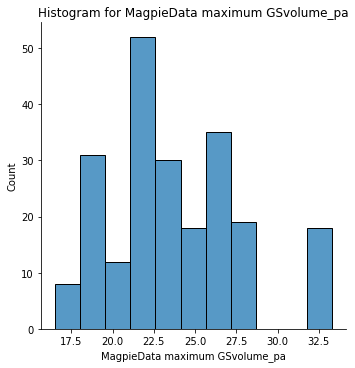

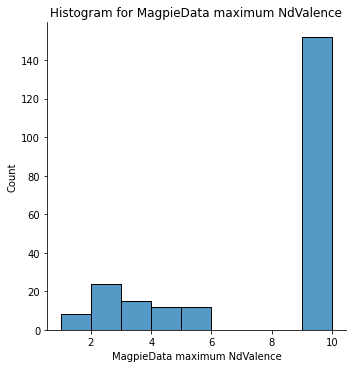

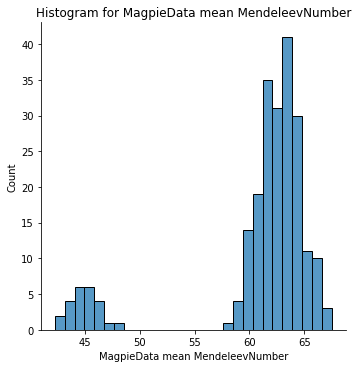

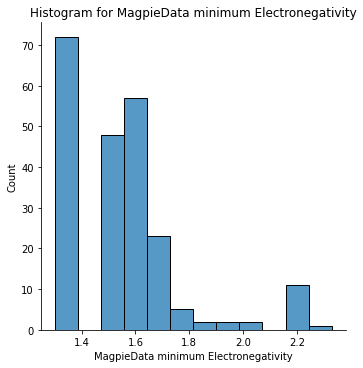

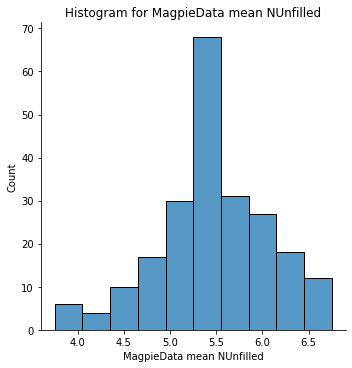

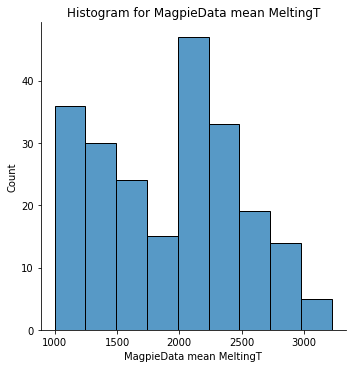

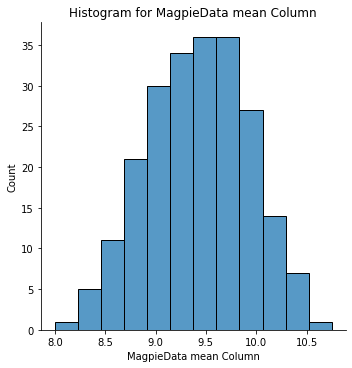

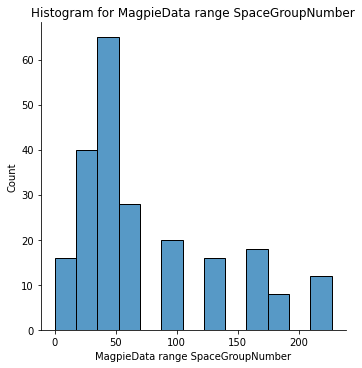

In [176]:
# Histogram plots.
flag_hist_plot = 1
if flag_hist_plot == 1:
    nMaxFeats = 11
    if len(df_features.columns) <= nMaxFeats:
        for feat in df_features.columns:
            sns.displot(df_features[feat])
            plt.title('Histogram for ' + feat)

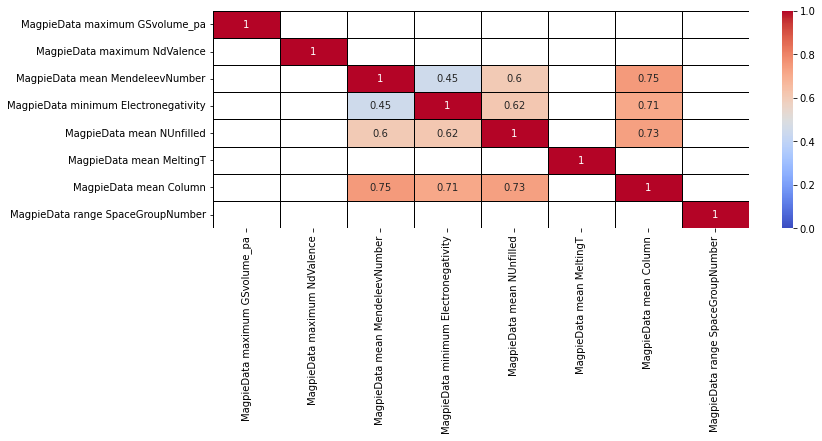

In [177]:
# Correlations among selected features.
if flag_selected_features != 0:
    corrmat = df_features.corr()
    thresh = 0.4
    flag_corr_plot = 1 # 0 = No, 1 = Yes
    if flag_corr_plot == 1:
        plt.figure(figsize=(12,4))
        sns.heatmap(abs(corrmat[abs(corrmat)>thresh]), vmax=1, vmin=0, annot=True, square=False, cmap="coolwarm", fmt='.2g', linewidths=.5, linecolor='black')

#### Step 4: Data splitting

In [178]:
# Split data into train and test.
rand_st_1 = 42 
split_frac_1 = 0.0 # No test data. The data will be split into train vs. validation later.
if split_frac_1 > 0.0:
    xTrain, xTest, yTrain, yTest = train_test_split(df_features, df_labels, test_size=split_frac_1, random_state=rand_st_1)
else:
    xTrain = df_features
    xTest = []
    yTrain = df_labels
    yTest = []
for ds in [yTrain, yTest]:
    print(len(ds), round(len(ds)/len(df_labels),2))

223 1.0
0 0.0


In [179]:
if split_frac_1 > 0.0:
    print(xTest.head())

In [180]:
if split_frac_1 > 0.0:
    print(yTest.head())

In [181]:
# Split data into train vs. validation.
rand_st_2 = 28 # Options used: 42, 0, 14, 28
split_frac_2 = 0.2
xTrain, xValidation, yTrain, yValidation = train_test_split(xTrain, yTrain, test_size=split_frac_2, random_state=rand_st_2)
for ds in [yTrain, yValidation, yTest]:
    print(len(ds), round(len(ds)/len(df_labels),2))

178 0.8
45 0.2
0 0.0


In [182]:
xValidation.head()

,MagpieData maximum GSvolume_pa,MagpieData maximum NdValence,MagpieData mean MendeleevNumber,MagpieData minimum Electronegativity,MagpieData mean NUnfilled,MagpieData mean MeltingT,MagpieData mean Column,MagpieData range SpaceGroupNumber
15,22.235,10.0,43.50,1.36,5.25,1071.3175,8.25,0.0
215,22.175,10.0,67.00,2.18,4.50,2135.7625,10.50,63.0
65,33.285,10.0,62.25,1.63,5.50,2173.5200,9.50,88.0
138,23.195,2.0,60.75,1.33,6.00,2441.5000,9.00,33.0
131,33.285,10.0,64.00,1.60,5.25,1517.0325,9.75,88.0


In [183]:
yValidation.head()

15     106
215    189
65     189
138    240
131    151
Name: elastic modulus, dtype: int64

In [184]:
# Feature scaling for sklearn.
flag_scaling_sk = 0 # 0 = none, 1 = minmax, 2 = standard
if flag_scaling_sk > 0:
    if flag_scaling_sk == 1:
        xscaler = MinMaxScaler()
        xscaler_name = 'MinMaxScaler'
    elif flag_scaling_sk == 2:
        xscaler = StandardScaler()
        xscaler_name = 'StdScaler'
    xscaler.fit(df_features)
    xTrain[selected_features] = xscaler.transform(xTrain[selected_features])
    xValidation[selected_features] = xscaler.transform(xValidation[selected_features])
    xTest[selected_features] = xscaler.transform(xTest[selected_features])
    df_features_scaled = pd.concat([xTrain,xValidation,xTest], axis=0)
    df_features_scaled.sort_index(inplace=True)
    df_features_final = df_features_scaled.copy()
else:
    xscaler_name = ''
    df_features_final = df_features.copy()
df_features_final.describe(percentiles=my_percentiles)

,MagpieData maximum GSvolume_pa,MagpieData maximum NdValence,MagpieData mean MendeleevNumber,MagpieData minimum Electronegativity,MagpieData mean NUnfilled,MagpieData mean MeltingT,MagpieData mean Column,MagpieData range SpaceGroupNumber
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,23.843027,7.753363,60.852018,1.551256,5.440583,1931.315673,9.424888,72.318386
std,4.038492,3.372808,5.796713,0.215187,0.613843,569.005670,0.548049,61.951899
min,16.480000,1.000000,42.250000,1.300000,3.750000,998.490000,8.000000,0.000000
1%,16.480000,1.000000,43.305000,1.300000,3.805000,1022.128950,8.250000,0.000000
2.5%,16.595500,1.000000,44.025000,1.300000,4.137500,1063.968625,8.387500,0.000000
5%,18.247750,2.000000,44.775000,1.300000,4.500000,1095.583250,8.500000,0.000000
10%,18.857500,2.000000,47.200000,1.300000,4.750000,1185.387500,8.750000,28.000000
25%,22.175000,4.000000,61.000000,1.360000,5.000000,1388.822500,9.000000,34.000000
50%,23.005000,10.000000,62.500000,1.540000,5.500000,2011.817500,9.500000,35.000000


In [185]:
if (len(yTest)>0):
    xStacked = pd.concat([xTrain, xValidation, xTest], axis=0)
    yStacked = np.concatenate([yTrain, yValidation, yTest])
else:
    xStacked = pd.concat([xTrain, xValidation], axis=0)
    yStacked = np.concatenate([yTrain, yValidation])   

#### Step 5: XGB model development

In [186]:
def print_metrics(true, predicted):
    print(r2_score(true, predicted))
    print(explained_variance_score(true, predicted))
    print(max_error(true, predicted))

In [187]:
def print_model_scores(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    if mse >= 0:
        rmse = np.sqrt(mean_squared_error(actual, predicted))
    else:
        rmse = np.sqrt(large_num)
    r2 = r2_score(actual, predicted)
    maxerr = max_error(actual, predicted)
    stderr_diff = sp.stats.sem(actual-predicted)
    stdev_diff = stderr_diff * (len(actual)**0.5)
    print(
        'MAE:', '%.2E' % Decimal(mae), 
        'MSE:', '%.2E' % Decimal(mse),
        'RMSE:', '%.2E' % Decimal(rmse),
        'R2:', round(r2,3),
        'MaxE:', '%.2E' % Decimal(maxerr), 
        'SED:', '%.2E' % Decimal(stderr_diff), 
        'SDD:', '%.2E' % Decimal(stdev_diff)
        )
    return [mae, mse, rmse, r2, maxerr, stderr_diff, stdev_diff]

In [188]:
def print_model_results(results):
    print('Best parameters: {}\n'.format(results.best_params_))
    try:
        print('Lowest RMSE: ', round(np.sqrt(results.best_score_),3))
    except:
        print('Lowest RMSE: ', round(np.sqrt(large_num),3))
    cv_means = results.cv_results_['mean_test_score']
    cv_stdevs = results.cv_results_['std_test_score']
    for m, s, p in zip(cv_means, cv_stdevs, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(m, 3), round(s*2, 3), p))

In [189]:
# Grid search cross-validation (CV) and hyperparameter optimization.
flag_grid_search_sk = 1 # -1 = skip, 0 = base model but no grid search, 1 = yes
if flag_grid_search_sk == -1:
    pass
else:
    flag_SK_model = 1
    model_name = 'XGBoost'
    myRegModel = XGBRegressor()
    model_params = {
        'n_estimators': [10, 25, 50, 75, 100],
        'learning_rate': [0.01, 0.03, 0.1, 0.3], # eta
        'max_depth': [4, 6, 8],
        'min_split_loss': [1, 3, 5] # gamma
    }
    if flag_grid_search_sk == 0:
        fit = myRegModel.fit(xTrain, yTrain.values.flatten())
        yTrainPredict = myRegModel.predict(xTrain)
        print_model_scores(yTrain, yTrainPredict)        
        myOptModel = myRegModel
    elif flag_grid_search_sk == 1:
        cv = GridSearchCV(myRegModel, model_params, n_jobs=-1, cv=5)
        cv.fit(xTrain, yTrain.values.ravel())
        print_model_results(cv)
        myOptModel = cv.best_estimator_

Best parameters: {'learning_rate': 0.3, 'max_depth': 4, 'min_split_loss': 3, 'n_estimators': 100}

Lowest RMSE:  0.874
-11.182 (+/-4.361) for {'learning_rate': 0.01, 'max_depth': 4, 'min_split_loss': 1, 'n_estimators': 10}
-8.19 (+/-3.157) for {'learning_rate': 0.01, 'max_depth': 4, 'min_split_loss': 1, 'n_estimators': 25}
-4.774 (+/-1.737) for {'learning_rate': 0.01, 'max_depth': 4, 'min_split_loss': 1, 'n_estimators': 50}
-2.681 (+/-0.939) for {'learning_rate': 0.01, 'max_depth': 4, 'min_split_loss': 1, 'n_estimators': 75}
-1.405 (+/-0.506) for {'learning_rate': 0.01, 'max_depth': 4, 'min_split_loss': 1, 'n_estimators': 100}
-11.182 (+/-4.361) for {'learning_rate': 0.01, 'max_depth': 4, 'min_split_loss': 3, 'n_estimators': 10}
-8.19 (+/-3.157) for {'learning_rate': 0.01, 'max_depth': 4, 'min_split_loss': 3, 'n_estimators': 25}
-4.774 (+/-1.737) for {'learning_rate': 0.01, 'max_depth': 4, 'min_split_loss': 3, 'n_estimators': 50}
-2.681 (+/-0.939) for {'learning_rate': 0.01, 'max_depth

In [190]:
myOptModel.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 3,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 4,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'min_split_loss': 3}

In [191]:
# Model metrics.
if flag_SK_model == 1:
    print('Model type: ', model_name)
    print('---- Training ----')
    yTrainPredict = myOptModel.predict(xTrain)
    print_model_scores(yTrain, yTrainPredict)
    print('---- Validation ----')
    yValidationPredict = myOptModel.predict(xValidation)
    print_model_scores(yValidation, yValidationPredict)

Model type:  XGBoost
---- Training ----
MAE: 1.40E+00 MSE: 3.16E+00 RMSE: 1.78E+00 R2: 0.999 MaxE: 5.43E+00 SED: 1.34E-01 SDD: 1.78E+00
---- Validation ----
MAE: 2.53E+01 MSE: 1.09E+03 RMSE: 3.31E+01 R2: 0.721 MaxE: 9.48E+01 SED: 4.98E+00 SDD: 3.34E+01


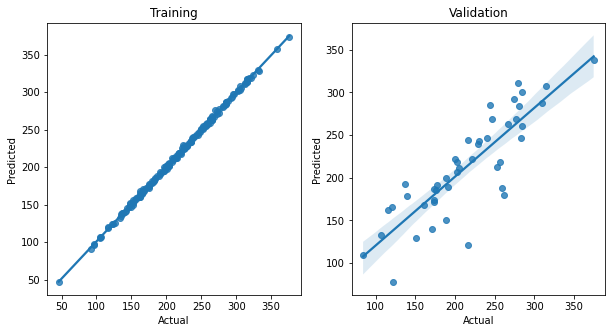

In [192]:
# Parity plots.
if flag_SK_model == 1:
    foo_Train = pd.DataFrame({'Actual': yTrain, 'Predicted': yTrainPredict})
    foo_Validation = pd.DataFrame({'Actual': yValidation, 'Predicted': yValidationPredict})
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(121)
    goo = sns.regplot(data=foo_Train, x='Actual', y='Predicted')
    goo.set_title('Training')
    plt.subplot(122)
    goo = sns.regplot(data=foo_Validation, x='Actual', y='Predicted')
    goo.set_title('Validation')
    plt.show()

In [193]:
# Store model to disk.
flag_model_save_sk = 1
if flag_model_save_sk == 1:
    prefix = target.replace(" ", "")
    suffix = '_tts8020_rs'
    model_name_full = 'saved_models' + '\\' + prefix + '_' + model_name + suffix + str(rand_st_2) + '.pkl'
    joblib.dump(myOptModel, model_name_full, compress=0)
    if flag_scaling_sk > 0:
        xscaler_name_full = 'saved_models' + '\\' + prefix + '_' + xscaler_name + suffix + str(rand_st_2) + '.pkl'
        joblib.dump(xscaler, xscaler_name_full, compress=0)

#### Step 6: Feature importance and partial dependence

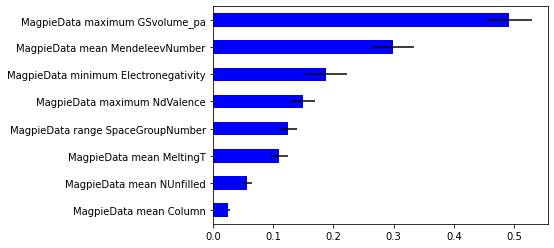

In [194]:
# Permutation importance.
perm_imp = permutation_importance(myOptModel, X=pd.concat([xTrain, xValidation]), y=pd.concat([yTrain,yValidation]), n_repeats=10, random_state=rand_st_2)
perm_imp_std = perm_imp.importances_std
perm_imp = perm_imp.importances_mean
ntop = 15
ind_sort = np.argsort(perm_imp)[-ntop:]
perm_imp = pd.Series(perm_imp, index=xTrain.columns)
perm_imp = perm_imp[ind_sort]
perm_imp_std = perm_imp_std[ind_sort]
fig, ax = plt.subplots()
perm_imp.plot.barh(xerr=perm_imp_std, ax=ax, color='b')
plt.show()

In [195]:
# Model predictions and metrics.
myBestModel = myOptModel # Select the best model here. Default could be the current model.
print('Model type: ', model_name)
print('---- Training ----')
yTrainPredict = myBestModel.predict(xTrain)
print_model_scores(yTrain, yTrainPredict)
print('---- Validation ----')
yValidationPredict = myBestModel.predict(xValidation)
print_model_scores(yValidation, yValidationPredict)
if len(yTest) > 0:
    print('---- Test ----')
    yTestPredict = myBestModel.predict(xTest)
    print_model_scores(yTest, yTestPredict)
print('---- All data ----')
yAllDataPredict = myBestModel.predict(df_features_final)
print_model_scores(df_labels, yAllDataPredict)

Model type:  XGBoost
---- Training ----
MAE: 1.40E+00 MSE: 3.16E+00 RMSE: 1.78E+00 R2: 0.999 MaxE: 5.43E+00 SED: 1.34E-01 SDD: 1.78E+00
---- Validation ----
MAE: 2.53E+01 MSE: 1.09E+03 RMSE: 3.31E+01 R2: 0.721 MaxE: 9.48E+01 SED: 4.98E+00 SDD: 3.34E+01
---- All data ----
MAE: 6.21E+00 MSE: 2.23E+02 RMSE: 1.49E+01 R2: 0.94 MaxE: 9.48E+01 SED: 1.00E+00 SDD: 1.50E+01


[6.213733416501717,
 223.0502266229309,
 14.934866140107546,
 0.9397537583412655,
 94.78583526611328,
 1.0020908396978185,
 14.96440741808376]

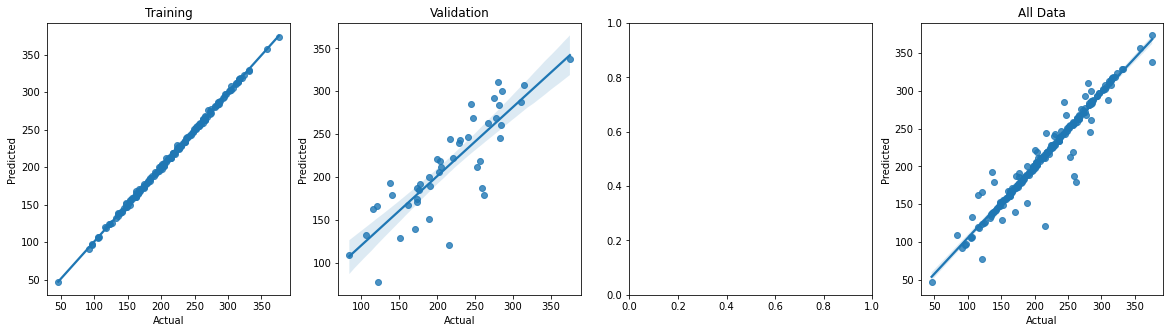

In [196]:
# Parity plots.
#foo_Train = pd.DataFrame({'Actual': yTrain, 'Predicted': yTrainPredict})
#foo_Validation = pd.DataFrame({'Actual': yValidation, 'Predicted': yValidationPredict})
if len(yTest) > 0:
    foo_Test = pd.DataFrame({'Actual': yTest, 'Predicted': yTestPredict})
foo_AllData = pd.DataFrame({'Actual': df_labels, 'Predicted': yAllDataPredict})
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plt.subplot(141)
goo = sns.regplot(data=foo_Train, x='Actual', y='Predicted')
goo.set_title('Training')
plt.subplot(142)
goo = sns.regplot(data=foo_Validation, x='Actual', y='Predicted')
goo.set_title('Validation')
if len(yTest) > 0:
    plt.subplot(143)
    goo = sns.regplot(data=foo_Test, x='Actual', y='Predicted')
    goo.set_title('Test')
plt.subplot(144)
goo = sns.regplot(data=foo_AllData, x='Actual', y='Predicted')
goo.set_title('All Data')
plt.show()

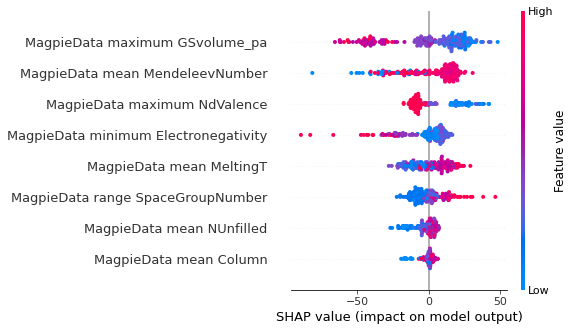

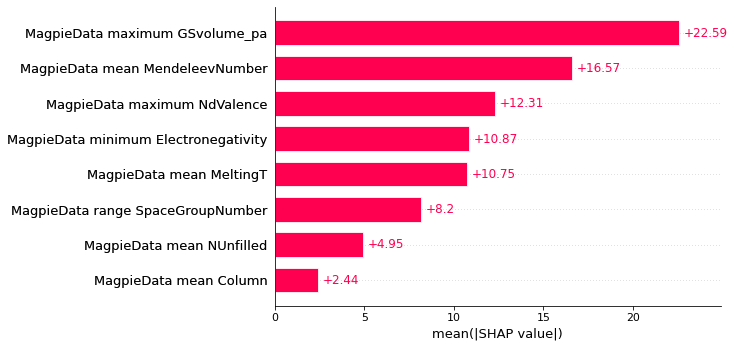

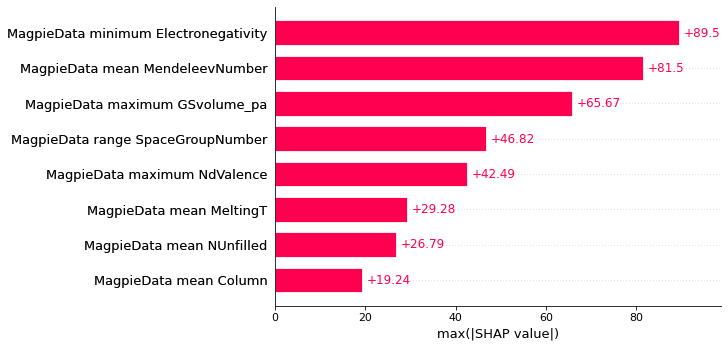

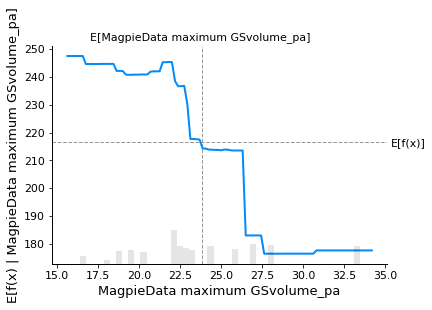

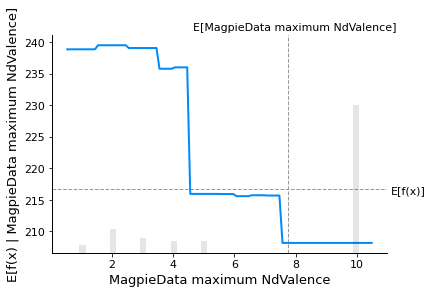

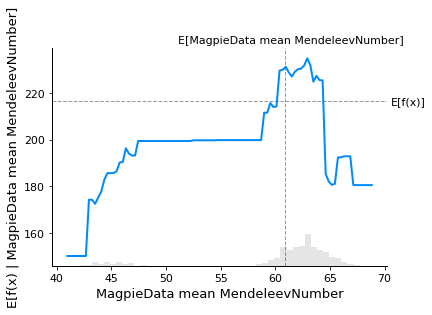

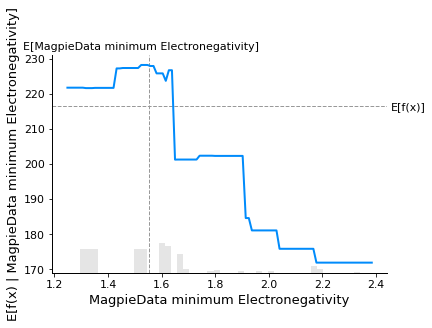

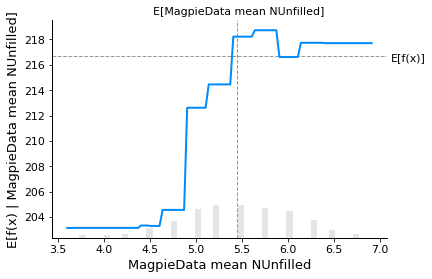

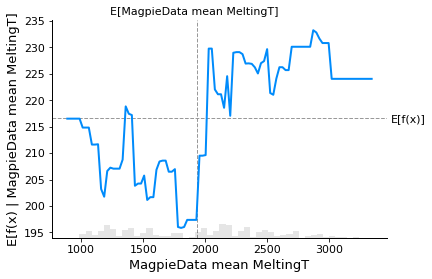

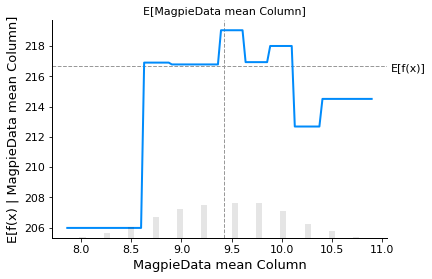

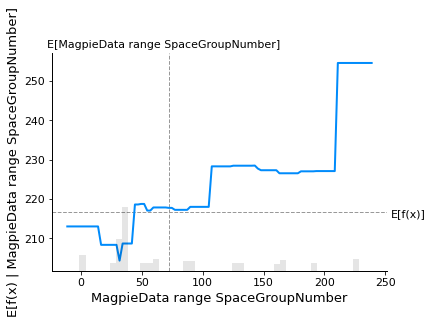

In [197]:
# SHAP plots.
flag_shap = 1
flag_shap_pdp_plots = 1
shap_inp = pd.concat([xTrain, xValidation])
explainer = shap.TreeExplainer(myBestModel)
shap_vals = explainer(shap_inp)
shap.summary_plot(shap_vals.values, shap_inp)
shap.plots.bar(shap_vals)
shap.plots.bar(shap_vals.abs.max(0))
nMaxVars = 20
if flag_shap_pdp_plots == 1 and len(df_features_final.columns) < nMaxVars:
    for i, v in enumerate(df_features_final.columns):
        shap.partial_dependence_plot(v, myBestModel.predict, shap_inp, ice=False, feature_expected_value=True, model_expected_value=True)

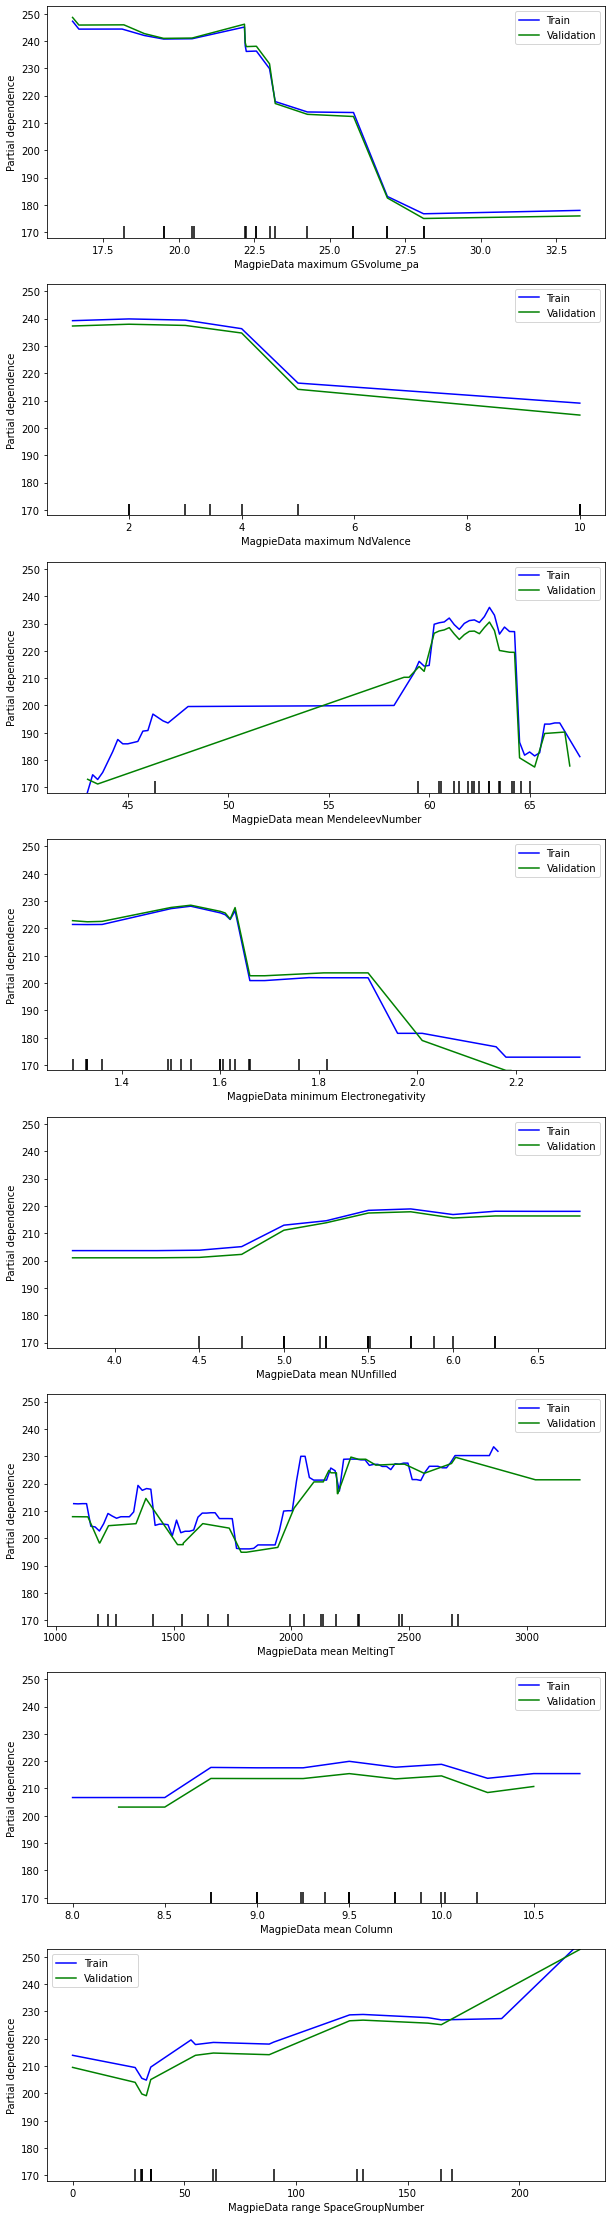

In [198]:
# Partial dependence plots.
flag_pdp_plots = 1
nMaxVars = 20
nFeats = len(df_features_final.columns)
if flag_pdp_plots == 1 and nFeats < nMaxVars:
    fig, ax = plt.subplots(nFeats, 1, figsize=(10, 5*nFeats))
    if len(yTest) > 0:
        list_ds = ['Train', 'Validation', 'Test']
        list_colors = ['blue', 'green', 'red']
    else:
        list_ds = ['Train', 'Validation']
        list_colors = ['blue', 'green']
    for i, v in enumerate(zip(list_ds,list_colors)):
        foo_x = eval('x' + v[0])
        disp = PartialDependenceDisplay.from_estimator(myBestModel, foo_x, df_features_final.columns, 
                                                       ax=ax, line_kw={'label': v[0], 'color': v[1]})

In [199]:
$ # Intentional error to allow for user selection.

SyntaxError: invalid syntax (422673384.py, line 1)

#### Step 7: Predictions using ensemble of models

In [202]:
# Ensemble of models using different random states used in data splitting.
list_models = [
    'elasticmodulus_XGBoost_tts8020_rs42',
    'elasticmodulus_XGBoost_tts8020_rs0',
    'elasticmodulus_XGBoost_tts8020_rs14',
    'elasticmodulus_XGBoost_tts8020_rs28',
]

elasticmodulus_XGBoost_tts8020_rs42
{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 5, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 75, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'min_split_loss': 5}
elasticmodulus_XGBoost_tts8020_rs0
{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsamp

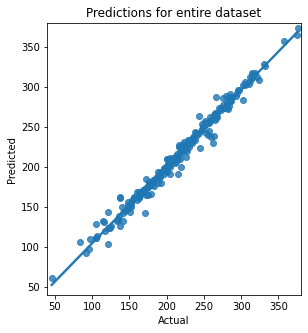

In [213]:
# Run ensemble of models for original data (all points).
yAllPredictSum = np.zeros(len(df_features_save))
for mdl in list_models:
    mdl_folder_path = r'saved_models\\'
    print(mdl)
    this_model = joblib.load(mdl_folder_path + mdl + '.pkl')
    print(this_model.get_params())
    yAllPredict = this_model.predict(df_features_save[selected_features])
    yAllPredictSum = yAllPredictSum + yAllPredict
yAllPredictAvg = yAllPredictSum / len(list_models)
print_metrics(df_labels, yAllPredictAvg)
print_model_scores(df_labels, yAllPredictAvg)
foo = pd.DataFrame({'Actual': df_labels, 'Predicted': yAllPredictAvg})
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.subplot(121)
goo = sns.regplot(data=foo, x='Actual', y='Predicted')
goo.set_title('Predictions for entire dataset')
goo.set_xlim([40, 380])
goo.set_ylim([40, 380])
plt.show()

nModels = 4
Loaded model = elasticmodulus_XGBoost_tts8020_rs42
Loaded model = elasticmodulus_XGBoost_tts8020_rs0
Loaded model = elasticmodulus_XGBoost_tts8020_rs14
Loaded model = elasticmodulus_XGBoost_tts8020_rs28
Number of invalid models = 0


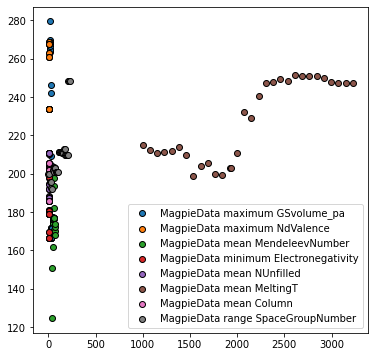

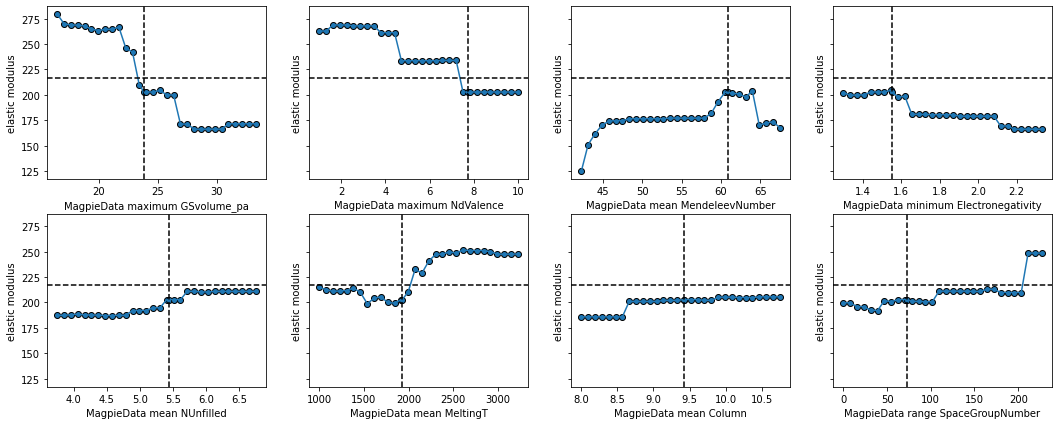

,Pred_avg,Pred_min,Pred_max,Pred_range,Pred_stdev
sample_0,202.796555,195.100128,213.409195,18.309067,7.808235
sample_1,279.381950,272.031952,289.411316,17.379364,7.374574
sample_2,269.855148,260.504578,273.582581,13.078003,6.292547
sample_3,268.710205,260.504578,272.769989,12.265411,5.586878
sample_4,268.608009,260.504578,272.769989,12.265411,5.520528
...,...,...,...,...,...
sample_236,209.762447,198.991089,218.235214,19.244125,8.251349
sample_237,209.762447,198.991089,218.235214,19.244125,8.251349
sample_238,248.533390,226.413635,259.615845,33.202209,15.013015
sample_239,248.533390,226.413635,259.615845,33.202209,15.013015


In [208]:
# Sensitivity analysis (partial dependence of target on features).
flag_pdp_sensitivity = 1
nSimsPerFeature = 30
if flag_pdp_sensitivity == 0:
    df_pdp = pd.DataFrame(np.nan, index=[], columns=[])
else:
    features_avg = df_features_final.mean(axis=0)
    features_min = df_features_final.min(axis=0)
    features_max = df_features_final.max(axis=0)
    features_range = features_max - features_min
    nRows = (nSimsPerFeature * len(df_features_final.columns)) + 1
    df_pdp_X = pd.DataFrame(np.nan, index=list('sample_' + str(int(vr)) for vr in range(nRows)), columns=df_features_final.columns)
    df_pdp_X.iloc[0] = features_avg
    for i, r in enumerate(range(1,nRows)):
        df_pdp_X.iloc[r] = features_avg
    for j, f in enumerate(df_features_final.columns):
        for i, r in enumerate(range(nSimsPerFeature)):
            RowNums = 1 + i + nSimsPerFeature*j
            df_pdp_X[f].iloc[RowNums] = features_min[f] + features_range[f] * (i/(nSimsPerFeature-1))
    AllRuns = list(range(0,nRows))
    nModels = len(list_models)
    print('nModels = {}'.format(nModels))
    ColHeaders = ['Pred_avg', 'Pred_min', 'Pred_max', 'Pred_range', 'Pred_stdev']
    RowHeaders = list('model_' + str(int(iM)) for iM in range(nModels))
    SampleList = list('sample_' + str(int(vr)) for vr in AllRuns)
    df_pdp = pd.DataFrame(np.nan, index=SampleList, columns=ColHeaders)
    df_pdp_Y = pd.DataFrame(np.nan, index=RowHeaders, columns=SampleList)
    nInvalidModels = 0
    RowIndStart = 0
    RowIndEnd = RowIndStart + 1
    mdl_folder_path = r'saved_models\\'
    for kmdl, mdl in enumerate(list_models):
        this_model = joblib.load(mdl_folder_path + mdl + '.pkl')
        print('Loaded model = {}'.format(mdl))
        try:
            yAllPred = this_model.predict(df_pdp_X.iloc[AllRuns])
            yAllPred = pd.DataFrame(yAllPred, index=AllRuns, columns=[target])
            df_pdp_Y.iloc[RowIndStart:RowIndEnd] = yAllPred.T
        except:
            print('Invalid model = {}'.format(mdl))
            nInvalidModels += 1
        RowIndStart = RowIndEnd
        RowIndEnd = RowIndStart + 1
    print('Number of invalid models = {}'.format(nInvalidModels))
    RowHeaders = list('sample_' + str(int(iAR)) for iAR in AllRuns)
    df_pdp = pd.DataFrame(np.nan, index=RowHeaders, columns=ColHeaders)
    df_pdp['Pred_avg'] = df_pdp_Y.mean()
    df_pdp['Pred_stdev'] = df_pdp_Y.std()
    df_pdp['Pred_min'] = df_pdp_Y.min()
    df_pdp['Pred_max'] = df_pdp_Y.max()
    df_pdp['Pred_range'] = df_pdp['Pred_max'] - df_pdp['Pred_min']
    RowBase = [0]
    plt.figure(figsize=(6,6))
    for i, v in enumerate(df_features_final.columns):
        ThisRowNums = RowBase + list(range(1+i*nSimsPerFeature, 1+(i+1)*nSimsPerFeature))
        dx = df_pdp_X.iloc[ThisRowNums]
        dy = df_pdp['Pred_avg'].iloc[ThisRowNums]
        dxy = pd.concat([dx, dy], axis=1)
        dxy.sort_values(v, inplace=True)
        plt.scatter(dxy[v], dxy['Pred_avg'], label=v, edgecolors='k')
    plt.legend()
    plt.show()
    nColsPlots = 4
    nRowsPlots = int(np.ceil(len(df_features_final.columns)/nColsPlots))
    fig, ax = plt.subplots(nrows=nRowsPlots, ncols=nColsPlots, sharex=False, sharey=True, figsize=(18, 3.5*nRowsPlots))
    ax = ax.ravel()
    for i,v in enumerate(df_features_final.columns):
        ThisRowNums = RowBase + list(range(1+i*nSimsPerFeature, 1+(i+1)*nSimsPerFeature))
        dx = df_pdp_X[v].loc[['sample_' + str(int(vr)) for vr in ThisRowNums]]
        dy = df_pdp['Pred_avg'].iloc[ThisRowNums]
        dxy = pd.concat([dx, dy], axis=1)
        dxy.sort_values(v, inplace=True)
        ax[i].scatter(dxy[v], dxy['Pred_avg'], label=v, edgecolors='k')
        ax[i].plot(dxy[v], dxy['Pred_avg'])
        ax[i].axhline(y=df_labels.mean(), color='black', linestyle='--')
        ax[i].axvline(x=df_features_final[v].mean(), color='black', linestyle='--')
        ax[i].set_xlabel(v)
        ax[i].set_ylabel(target)
        # ax[i].set_title('Effect of {} on {}'.format(v, target))
    plt.show()
df_pdp

#### Step 8: Exploration using ensemble of models

In [209]:
# Load 1080 M2AX combinations for exploration.
formulae = pd.read_csv('MAX_Compounds_for_Exploration.csv')
df_formulae = StrToComposition().featurize_dataframe(formulae, 'Formula')
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df_formulae = ep_feat.featurize_dataframe(df_formulae, col_id="composition")  
df_formulae.head()

StrToComposition:   0%|          | 0/1080 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/1080 [00:00<?, ?it/s]

,Formula,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,V2AlB,"(V, Al, B)",5.0,23.0,18.0,16.00,7.00,23.0,46.0,73.0,...,0.0,0.0,0.0,0.0,166.0,229.0,63.0,212.25,23.125,229.0
1,V2AlC,"(V, Al, C)",6.0,23.0,17.0,16.25,6.75,23.0,46.0,77.0,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,219.25,12.625,229.0
2,V2AlN,"(V, Al, N)",7.0,23.0,16.0,16.50,6.50,23.0,46.0,82.0,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,219.25,12.625,229.0
3,V2PB,"(V, P, B)",5.0,23.0,18.0,16.50,6.50,23.0,46.0,83.0,...,0.0,0.0,0.0,0.0,2.0,229.0,227.0,156.50,77.250,229.0
4,V2PC,"(V, P, C)",6.0,23.0,17.0,16.75,6.25,23.0,46.0,83.0,...,0.0,0.0,0.0,0.0,2.0,229.0,227.0,163.50,80.750,229.0


In [210]:
df_formulae.shape

(1080, 134)

In [215]:
# Run models for exploration.
yAllPredictSum = np.zeros(len(df_formulae))
for mdl in list_models:
    mdl_folder_path = r'saved_models\\'
    print(mdl)
    this_model = joblib.load(mdl_folder_path + mdl + '.pkl')
    yAllPredict = this_model.predict(df_formulae[selected_features])
    yAllPredictSum = yAllPredictSum + yAllPredict
yAllPredictAvg = yAllPredictSum / len(list_models)
print(yAllPredictAvg)
yAllPredAvg = pd.DataFrame({'Predict':yAllPredictAvg[0:len(df_formulae)]})
xlsxpath = r'MAX_Compounds_for_Exploration.xlsx'
wb = load_workbook(xlsxpath)
foo = pd.concat([yAllPredAvg, df_formulae[selected_features]], axis=1)
if 'output' in wb.sheetnames:
    wb.remove(wb['output'])
    wb.save(xlsxpath)
with pd.ExcelWriter(xlsxpath, mode = 'a') as writer:
    foo.to_excel(writer, sheet_name = 'output', index = False)

elasticmodulus_XGBoost_tts8020_rs42
elasticmodulus_XGBoost_tts8020_rs0
elasticmodulus_XGBoost_tts8020_rs14
elasticmodulus_XGBoost_tts8020_rs28
[273.17047882 316.05209351 304.06993103 ... 144.20724106 153.76708221
 142.12278557]


In [216]:
# Find feature values corresponding to the maximum prediction in the exploration.
df_formulae[df_features_final.columns].iloc[yAllPredAvg.idxmax()]

,MagpieData maximum GSvolume_pa,MagpieData maximum NdValence,MagpieData mean MendeleevNumber,MagpieData minimum Electronegativity,MagpieData mean NUnfilled,MagpieData mean MeltingT,MagpieData mean Column,MagpieData range SpaceGroupNumber
4,22.570238,3.0,63.0,1.63,5.25,2126.575,9.75,227.0


In [217]:
# Find feature values for any given material in the exploration.
df_formulae[df_features_final.columns][df_formulae['Formula']=='Ta2PB']

,MagpieData maximum GSvolume_pa,MagpieData maximum NdValence,MagpieData mean MendeleevNumber,MagpieData minimum Electronegativity,MagpieData mean NUnfilled,MagpieData mean MeltingT,MagpieData mean Column,MagpieData range SpaceGroupNumber
147,22.570238,3.0,62.75,1.5,5.5,2311.325,9.5,227.0


#### Step 9: Bayesian Optimization

In [222]:
df_features_final.describe()

,MagpieData maximum GSvolume_pa,MagpieData maximum NdValence,MagpieData mean MendeleevNumber,MagpieData minimum Electronegativity,MagpieData mean NUnfilled,MagpieData mean MeltingT,MagpieData mean Column,MagpieData range SpaceGroupNumber
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,23.843027,7.753363,60.852018,1.551256,5.440583,1931.315673,9.424888,72.318386
std,4.038492,3.372808,5.796713,0.215187,0.613843,569.005670,0.548049,61.951899
min,16.480000,1.000000,42.250000,1.300000,3.750000,998.490000,8.000000,0.000000
25%,22.175000,4.000000,61.000000,1.360000,5.000000,1388.822500,9.000000,34.000000
50%,23.005000,10.000000,62.500000,1.540000,5.500000,2011.817500,9.500000,35.000000
75%,26.910000,10.000000,63.750000,1.630000,6.000000,2349.350000,9.750000,90.000000
max,33.285000,10.000000,67.500000,2.330000,6.750000,3225.000000,10.750000,227.000000


In [223]:
feat_names = df_features_final.columns
feat_min = df_features_final.min(axis=0)
feat_max = df_features_final.max(axis=0)
feat_best = df_features_final.iloc[df_labels.idxmax()]

In [224]:
feat_best

MagpieData maximum GSvolume_pa            22.570238
MagpieData maximum NdValence               3.000000
MagpieData mean MendeleevNumber           63.000000
MagpieData minimum Electronegativity       1.630000
MagpieData mean NUnfilled                  5.250000
MagpieData mean MeltingT                2126.575000
MagpieData mean Column                     9.750000
MagpieData range SpaceGroupNumber        227.000000
Name: 52, dtype: float64

In [225]:
from skopt import gp_minimize
from skopt.plots import plot_convergence

In [226]:
# Specify bounds using min-max ranges of features.
my_pbounds = np.vstack([feat_min, feat_max]).T
my_pbounds

array([[1.6480e+01, 3.3285e+01],
       [1.0000e+00, 1.0000e+01],
       [4.2250e+01, 6.7500e+01],
       [1.3000e+00, 2.3300e+00],
       [3.7500e+00, 6.7500e+00],
       [9.9849e+02, 3.2250e+03],
       [8.0000e+00, 1.0750e+01],
       [0.0000e+00, 2.2700e+02]])

In [265]:
# Specify narrow bounds starting from the best features.
my_pbounds_narrow = np.vstack([feat_best*0.95, feat_best*1.05]).T
my_pbounds_narrow = np.sort(my_pbounds_narrow, axis=1)
my_pbounds_narrow

array([[2.14417262e+01, 2.36987500e+01],
       [2.85000000e+00, 3.15000000e+00],
       [5.98500000e+01, 6.61500000e+01],
       [1.54850000e+00, 1.71150000e+00],
       [4.98750000e+00, 5.51250000e+00],
       [2.02024625e+03, 2.23290375e+03],
       [9.26250000e+00, 1.02375000e+01],
       [2.15650000e+02, 2.38350000e+02]])

In [244]:
# Specify custom bounds.

# Option 1:
# feat_hardcoded = df_features_final.iloc[df_labels.idxmax()]

# Option 2:
# feat_hardcoded = df_formulae[df_features_final.columns].iloc[yAllPredAvg.idxmax()].squeeze()

# Option 3:
# feat_hardcoded = df_formulae[df_features_final.columns][df_formulae['Formula']=='Ta2PB'].squeeze()

# Option 4:
feat_hardcoded = feat_best.copy()
feat_hardcoded['MagpieData maximum GSvolume_pa'] = 21.8929
feat_hardcoded['MagpieData maximum NdValence'] = 3.00
feat_hardcoded['MagpieData mean MendeleevNumber'] = 62.7862
feat_hardcoded['MagpieData minimum Electronegativity'] = 1.6274
feat_hardcoded['MagpieData mean NUnfilled'] = 5.4075
feat_hardcoded['MagpieData mean MeltingT'] = 2159.995
feat_hardcoded['MagpieData mean Column'] = 9.4575
feat_hardcoded['MagpieData range SpaceGroupNumber'] = 230.00

my_pbounds_hardcoded = np.vstack([feat_hardcoded*0.8, feat_hardcoded*1.2]).T
my_pbounds_hardcoded = np.sort(my_pbounds_hardcoded, axis=1)
my_pbounds_hardcoded

array([[1.751432e+01, 2.627148e+01],
       [2.400000e+00, 3.600000e+00],
       [5.022896e+01, 7.534344e+01],
       [1.301920e+00, 1.952880e+00],
       [4.326000e+00, 6.489000e+00],
       [1.727996e+03, 2.591994e+03],
       [7.566000e+00, 1.134900e+01],
       [1.840000e+02, 2.760000e+02]])

In [266]:
def black_box_function_skopt(feat_vals):
    df_feats = pd.DataFrame(np.array([feat_vals]), index=['i',], columns=df_features_final.columns)
    fnames = ['MagpieData maximum NdValence', 'MagpieData range SpaceGroupNumber']
    for fn in fnames:
        if fn in selected_features:
            df_feats = df_feats.astype({fn: int})
    fn = 'MagpieData range SpaceGroupNumber'
    maxVal = 227
    df_feats[fn][df_feats[fn] >= maxVal] = maxVal
    if fn in selected_features:
        df_feats[fn]
    # print(df_feats)
    nModels = len(list_models)
    headers = ['ThisRun']
    df_yAllPredict = pd.DataFrame(np.nan, index=range(nModels), columns=headers)
    nFailed = 0
    for imdl, mdl in enumerate(list_models):
        mdl = 'saved_models' + '\\' + mdl + '.pkl'
        this_model = joblib.load(mdl)
        try:
            yAllPredict = this_model.predict(df_feats)
            df_yAllPredict.iloc[imdl] = yAllPredict
        except:
            nFailed += 1
    if nFailed > 0:
        print('Number of failed models = ', nFailed)
    yAllPredictAvg = df_yAllPredict.mean(axis=0)
    fcalc = yAllPredictAvg.loc['ThisRun']
    return -fcalc # maximize

In [267]:
print(black_box_function_skopt(feat_best.values))
print(black_box_function_skopt(feat_hardcoded.values))
print(black_box_function_skopt([22.03887456, 3, 62.81840527, 1.631266725, 5.326770396, 2214.786975, 9.557282735, 217]))

-373.53958892822266
-373.9415588378906
-374.21387481689453


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0390
Function value obtained: -310.8537
Current minimum: -310.8537
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0480
Function value obtained: -341.6321
Current minimum: -341.6321
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0540
Function value obtained: -309.4238
Current minimum: -341.6321
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0580
Function value obtained: -337.6980
Current minimum: -341.6321
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0650
Function value obtained: -344.4172
Current minimum: -344.4172
Itera

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

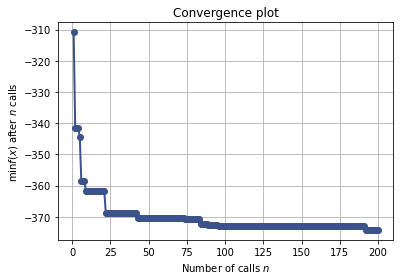

In [268]:
# Run Bayesian Optimization.
nip = 50 # Number of initial points.
nc = 150 + nip # Number of total iterations.
res = gp_minimize(
    func=black_box_function_skopt,
    dimensions=my_pbounds_narrow, # my_pbounds_hardcoded, # my_pbounds, # my_pbounds_narrow,
    acq_func="EI", # 'EI' # 'PI' # 'LCB' # 'gp_hedge'
    n_calls=nc,
    n_initial_points=nip,
    initial_point_generator='lhs', # 'lhs' # 'grid'
    # n_random_starts=5,
    random_state=42,
    n_jobs=-1,
    verbose=True,
    # xi=0.02,
    # x0=list(feat_best.values),
)
print('Optimum params: ', res.x)
print('Optimum fval: ', -res.fun)
plot_convergence(res)

In [269]:
black_box_function_skopt(res.x)

-374.21387481689453